# Two Planet Fit: Kepler 109

In [1]:
import exoplanet as xo
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time

import sys
sys.path.append("../helpers")
import data
import xo_archive

%config InlineBackend.figure_format = "retina"

# Potential Two Planet Systems

In [154]:
two_planet_systems = xo_archive.get_exoplanet_parameters(search_name="Kepler",
                                                         custom_cond="sy_pnum=2 and ttv_flag=0 and pl_rade > 1.5 and pl_rade < 2",
                                                         columns=["pl_name", "pl_letter"])

In [155]:
np.asarray(sorted(np.unique([x['pl_name'][:-1].rstrip() for x in two_planet_systems]),
                  key=lambda x: int(x.split("-")[1].split(" ")[0])))

array(['Kepler-69', 'Kepler-113', 'Kepler-118', 'Kepler-120',
       'Kepler-133', 'Kepler-135', 'Kepler-136', 'Kepler-137',
       'Kepler-140', 'Kepler-147', 'Kepler-158', 'Kepler-179',
       'Kepler-181', 'Kepler-188', 'Kepler-190', 'Kepler-195',
       'Kepler-200', 'Kepler-202', 'Kepler-204', 'Kepler-205',
       'Kepler-213', 'Kepler-225', 'Kepler-231', 'Kepler-236',
       'Kepler-243', 'Kepler-260', 'Kepler-262', 'Kepler-269',
       'Kepler-270', 'Kepler-273', 'Kepler-274', 'Kepler-291',
       'Kepler-294', 'Kepler-300', 'Kepler-309', 'Kepler-311',
       'Kepler-317', 'Kepler-321', 'Kepler-322', 'Kepler-323',
       'Kepler-329', 'Kepler-330', 'Kepler-337', 'Kepler-347',
       'Kepler-348', 'Kepler-349', 'Kepler-356', 'Kepler-360',
       'Kepler-364', 'Kepler-365', 'Kepler-366', 'Kepler-370',
       'Kepler-371', 'Kepler-376', 'Kepler-379', 'Kepler-382',
       'Kepler-386', 'Kepler-389', 'Kepler-400', 'Kepler-404',
       'Kepler-430', 'Kepler-501', 'Kepler-520', 'Kepler

# Get the data

Get all Kepler data using Lightkurve.

In [94]:
%%time
flat_lc = data.get_flattened_lc("Kepler-109", mission="Kepler", exptime=1800)

CPU times: user 4min 45s, sys: 30.7 s, total: 5min 16s
Wall time: 30.9 s


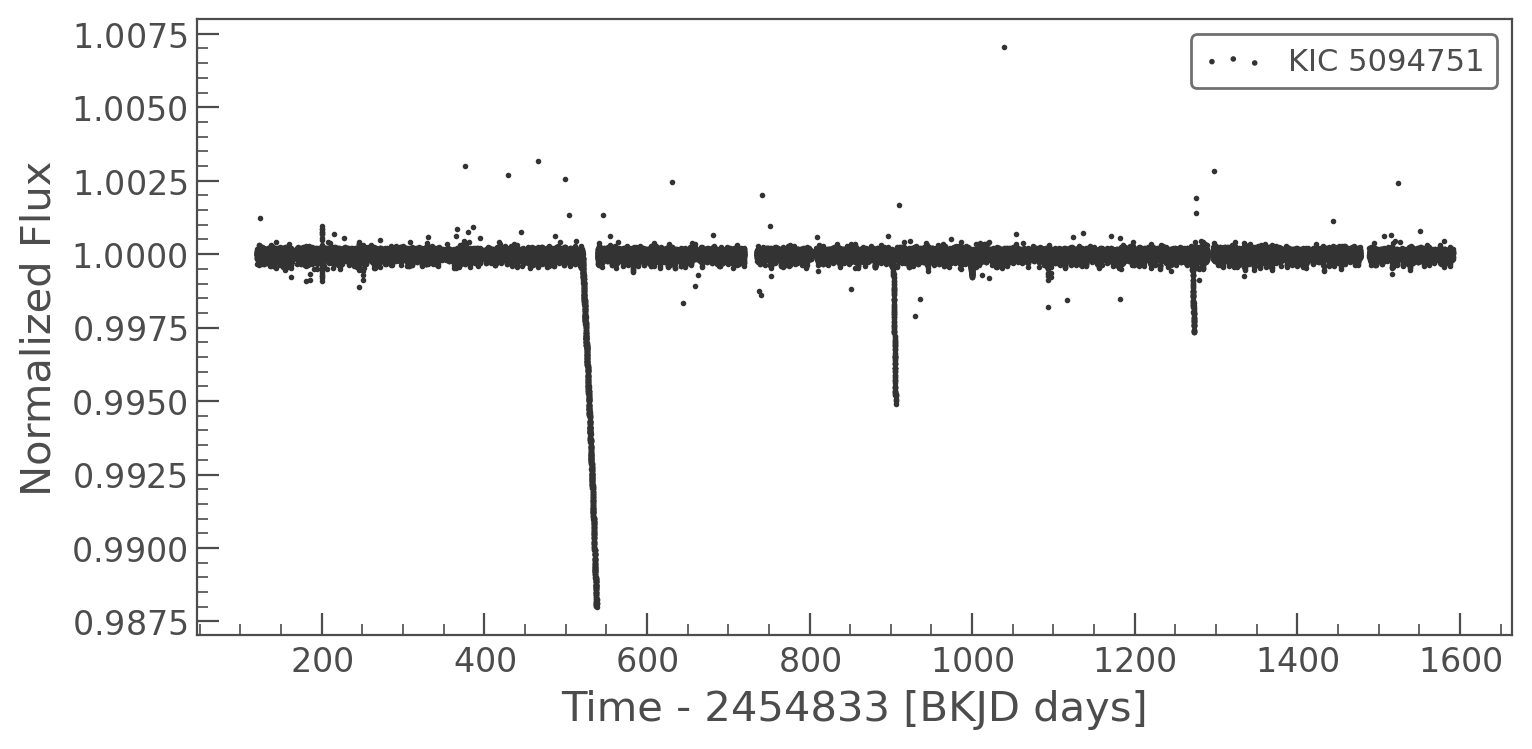

In [95]:
flat_lc.scatter()
plt.show()

# Remove outliers
Next we can remove outliers from the data, this is important but we have to be careful to avoid the transits. First we need the planet data

In [142]:
planet_parameters = xo_archive.get_exoplanet_parameters("kepler-109 ", which="composite")
n_planets = len(planet_parameters)
param_lists = xo_archive.transpose_parameters(planet_parameters)
param_lists

{'pl_name': ['Kepler-109 c', 'Kepler-109 b'],
 'pl_letter': ['c', 'b'],
 'pl_orbper': [21.22265, 6.4816307],
 'pl_orbincl': [89.63, 87.06],
 'pl_orbeccen': [0.098, 0.11],
 'pl_trandep': [0.03599, 0.03015],
 'pl_tranmid': [2454970.5722, 2454955.97791],
 'pl_trandur': [6.4913, 3.649],
 'pl_ratror': [0.01734, 0.01686],
 'pl_imppar': [0.16, 0.58],
 'st_dens': [0.65, 0.65]}

In [96]:
lc = data.remove_outliers(flat_lc, param_lists["pl_orbper"], param_lists["pl_tranmid"], param_lists["pl_trandur"],
                          transit_sigma_upper=5)

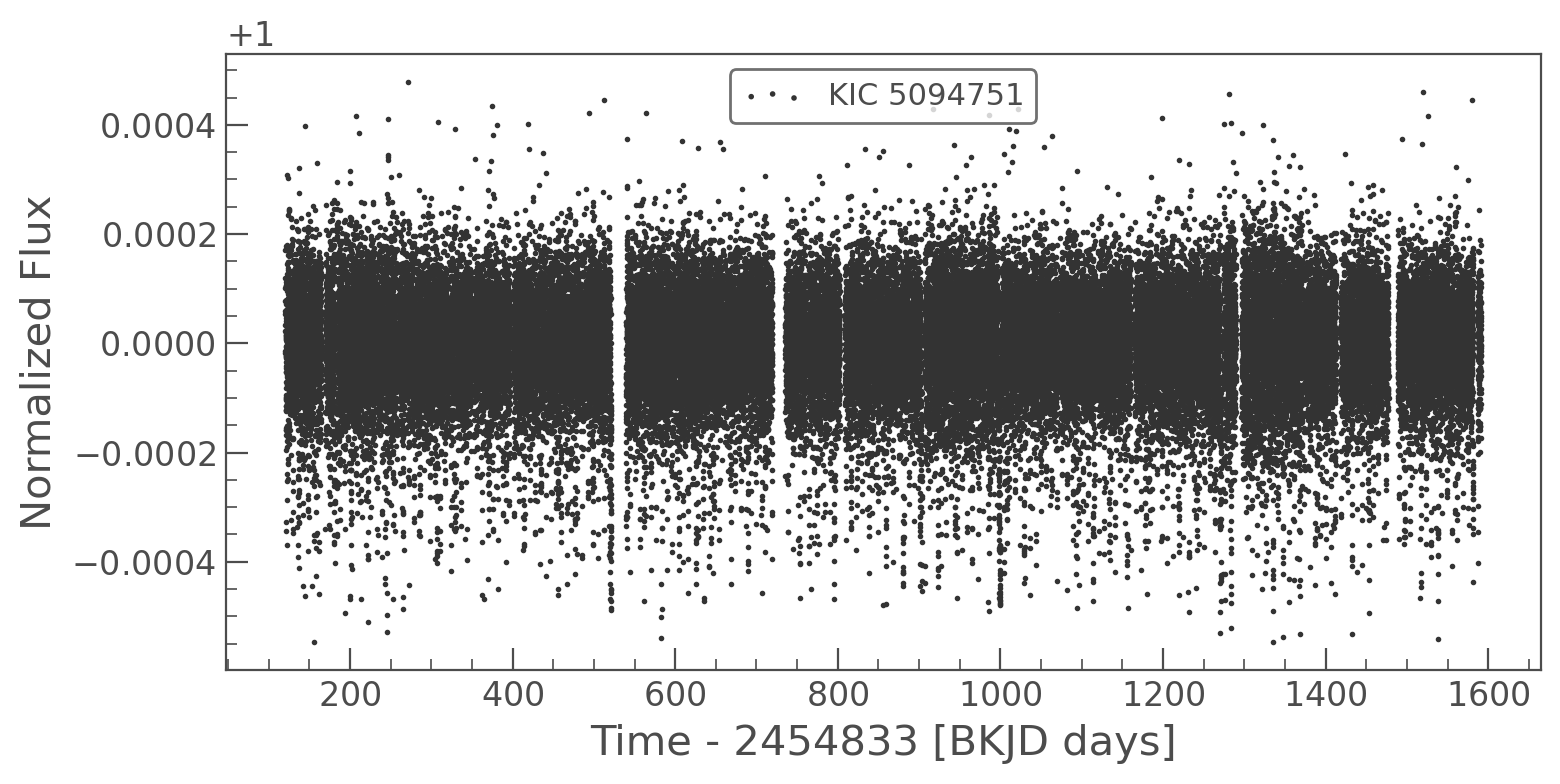

In [97]:
lc.scatter()
plt.show()

## Folded lightcurves

Now we can try folding the lightkurves at the different planet periods to check that they look good

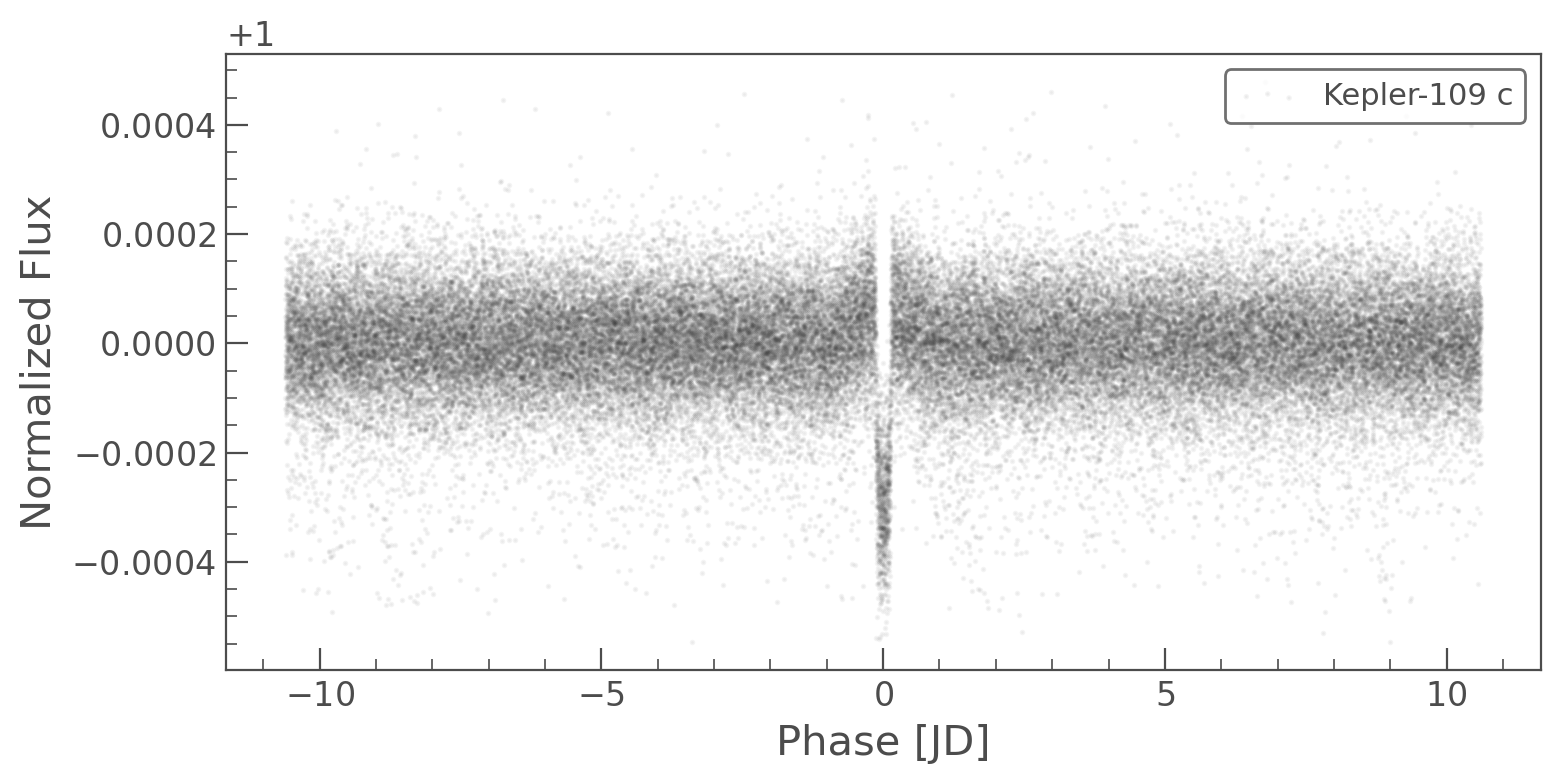

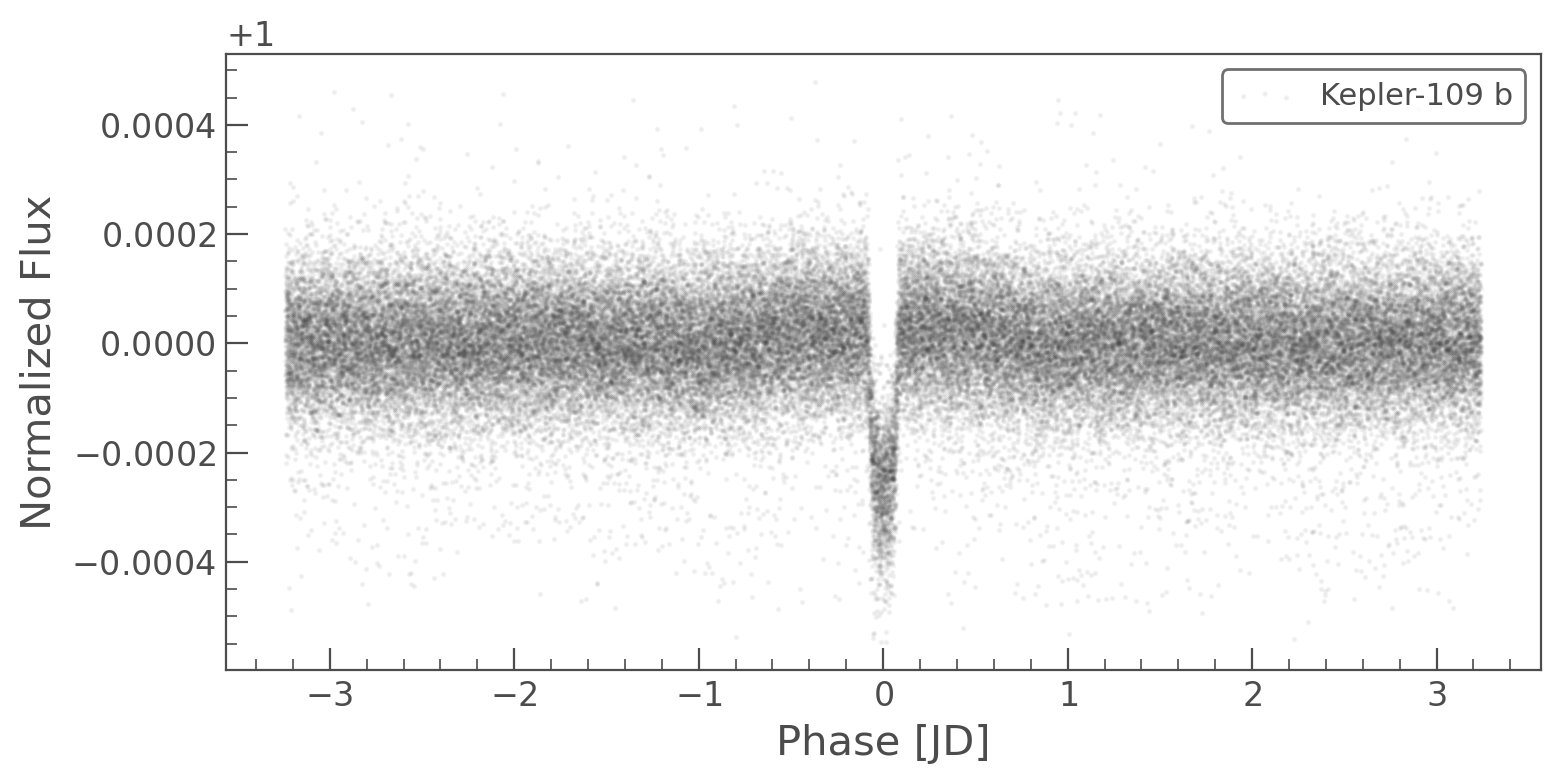

In [98]:
for i in range(len(planet_parameters)):
    ax = lc.fold(period=planet_parameters[i]["pl_orbper"],
                 epoch_time=Time(planet_parameters[i]["pl_tranmid"] * u.day,
                                 format="jd").bkjd).scatter(label=planet_parameters[i]["pl_name"], alpha=0.05)
    plt.show()

# Now to fit things

In [99]:
import fit

In [110]:
map_soln, model = fit.optimise_model(lc, param_lists)

optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 503698.2524504122 -> 504465.96114639856


# Let's see how the fit looks

In [111]:
param_lists

{'pl_name': ['Kepler-109 c', 'Kepler-109 b'],
 'pl_letter': ['c', 'b'],
 'pl_orbper': [21.22265, 6.4816307],
 'pl_orbincl': [89.63, 87.06],
 'pl_orbeccen': [0.098, 0.11],
 'pl_trandep': [0.03599, 0.03015],
 'pl_tranmid': [2454970.5722, 2454955.97791],
 'pl_trandur': [6.4913, 3.649],
 'pl_ratror': [0.01734, 0.01686],
 'pl_imppar': [0.16, 0.58],
 'st_dens': [0.65, 0.65]}

In [112]:
map_soln

{'mean': array(1.0000042),
 't0': array([137.57324663, 122.97693121]),
 'logP': array([3.05506871, 1.868973  ]),
 'u_quadlimbdark__': array([-1.37476934,  0.89376918]),
 'r_interval__': array([-1.66567323, -1.68489002]),
 'b_impact__': array([0.14257312, 0.91775551]),
 'log_rho_star': array(-0.35395289),
 'period': array([21.22264359,  6.48163634]),
 'u': array([ 0.63767535, -0.18839773]),
 'r': array([0.01674119, 0.01648845]),
 'b': array([0.54454932, 0.72636695]),
 'rho_star': array(0.44263638),
 'light_curves': array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])}

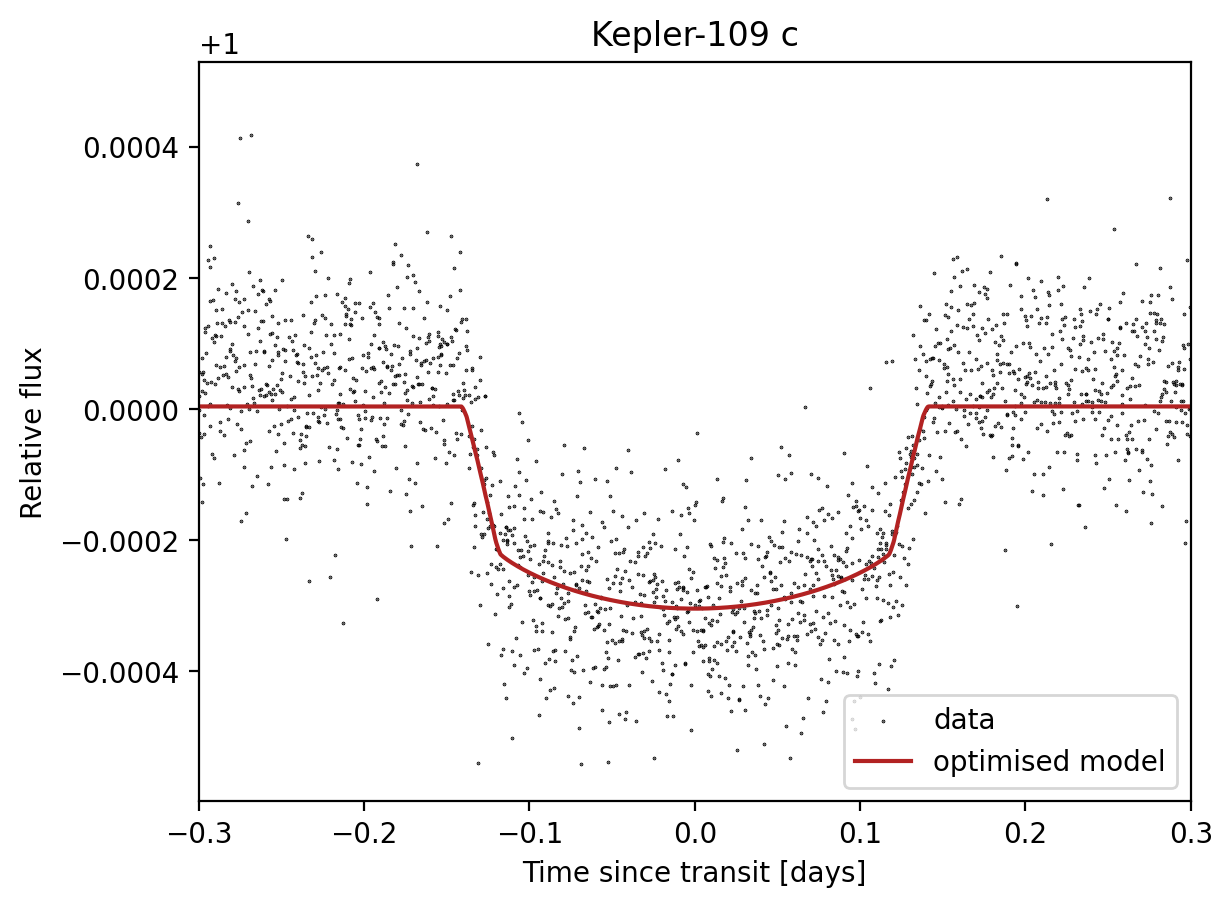

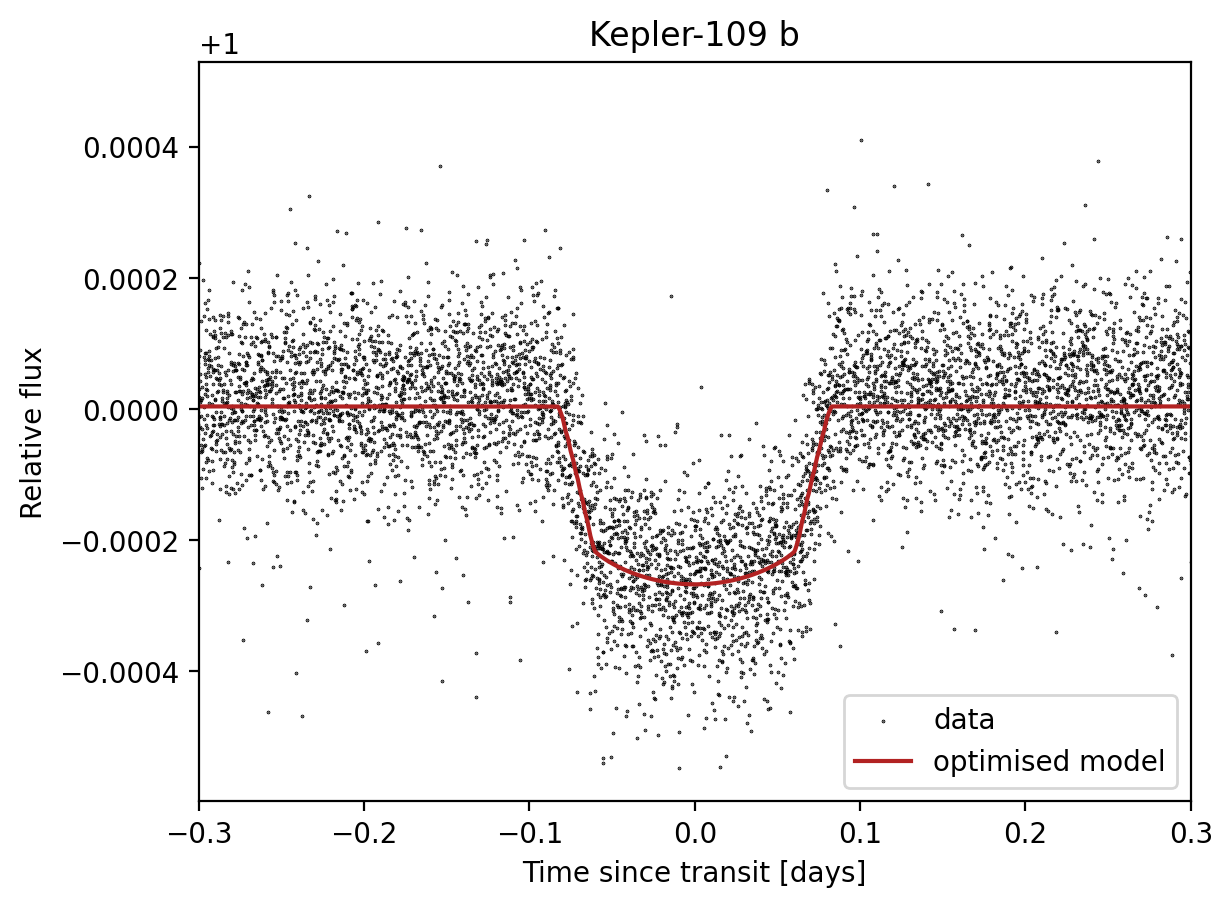

In [107]:
t = lc["time"].value
y = lc["flux"].value

for i in range(n_planets):
    plt.figure()

    p = map_soln["period"][i]
    t0 = map_soln["t0"][i]

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.scatter(
        x_fold, y, label="data", zorder=-1000, s=0.1, color="black"
    )

    # Plot the folded model within 0.3 days of the transit
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = map_soln["light_curves"][inds, i] + map_soln["mean"]
    plt.plot(x_fold[inds], pred, color="firebrick", label="optimised model")

    plt.ylabel("relative flux")
    plt.xlabel("time [days]")
    _ = plt.xlim(t.min(), t.max())

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("Time since transit [days]")
    plt.ylabel("Relative flux")
    plt.title(param_lists["pl_name"][i])
    plt.xlim(-0.3, 0.3)
    plt.show()

In [114]:
trace = fit.sample_posteriors(model, map_soln, cores=12, chains=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [log_rho_star, b, r, u, logP, t0, mean]


Sampling 12 chains for 1_000 tune and 1_000 draw iterations (12_000 + 12_000 draws total) took 2637 seconds.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6756423588336434, but should be close to 0.9. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or re

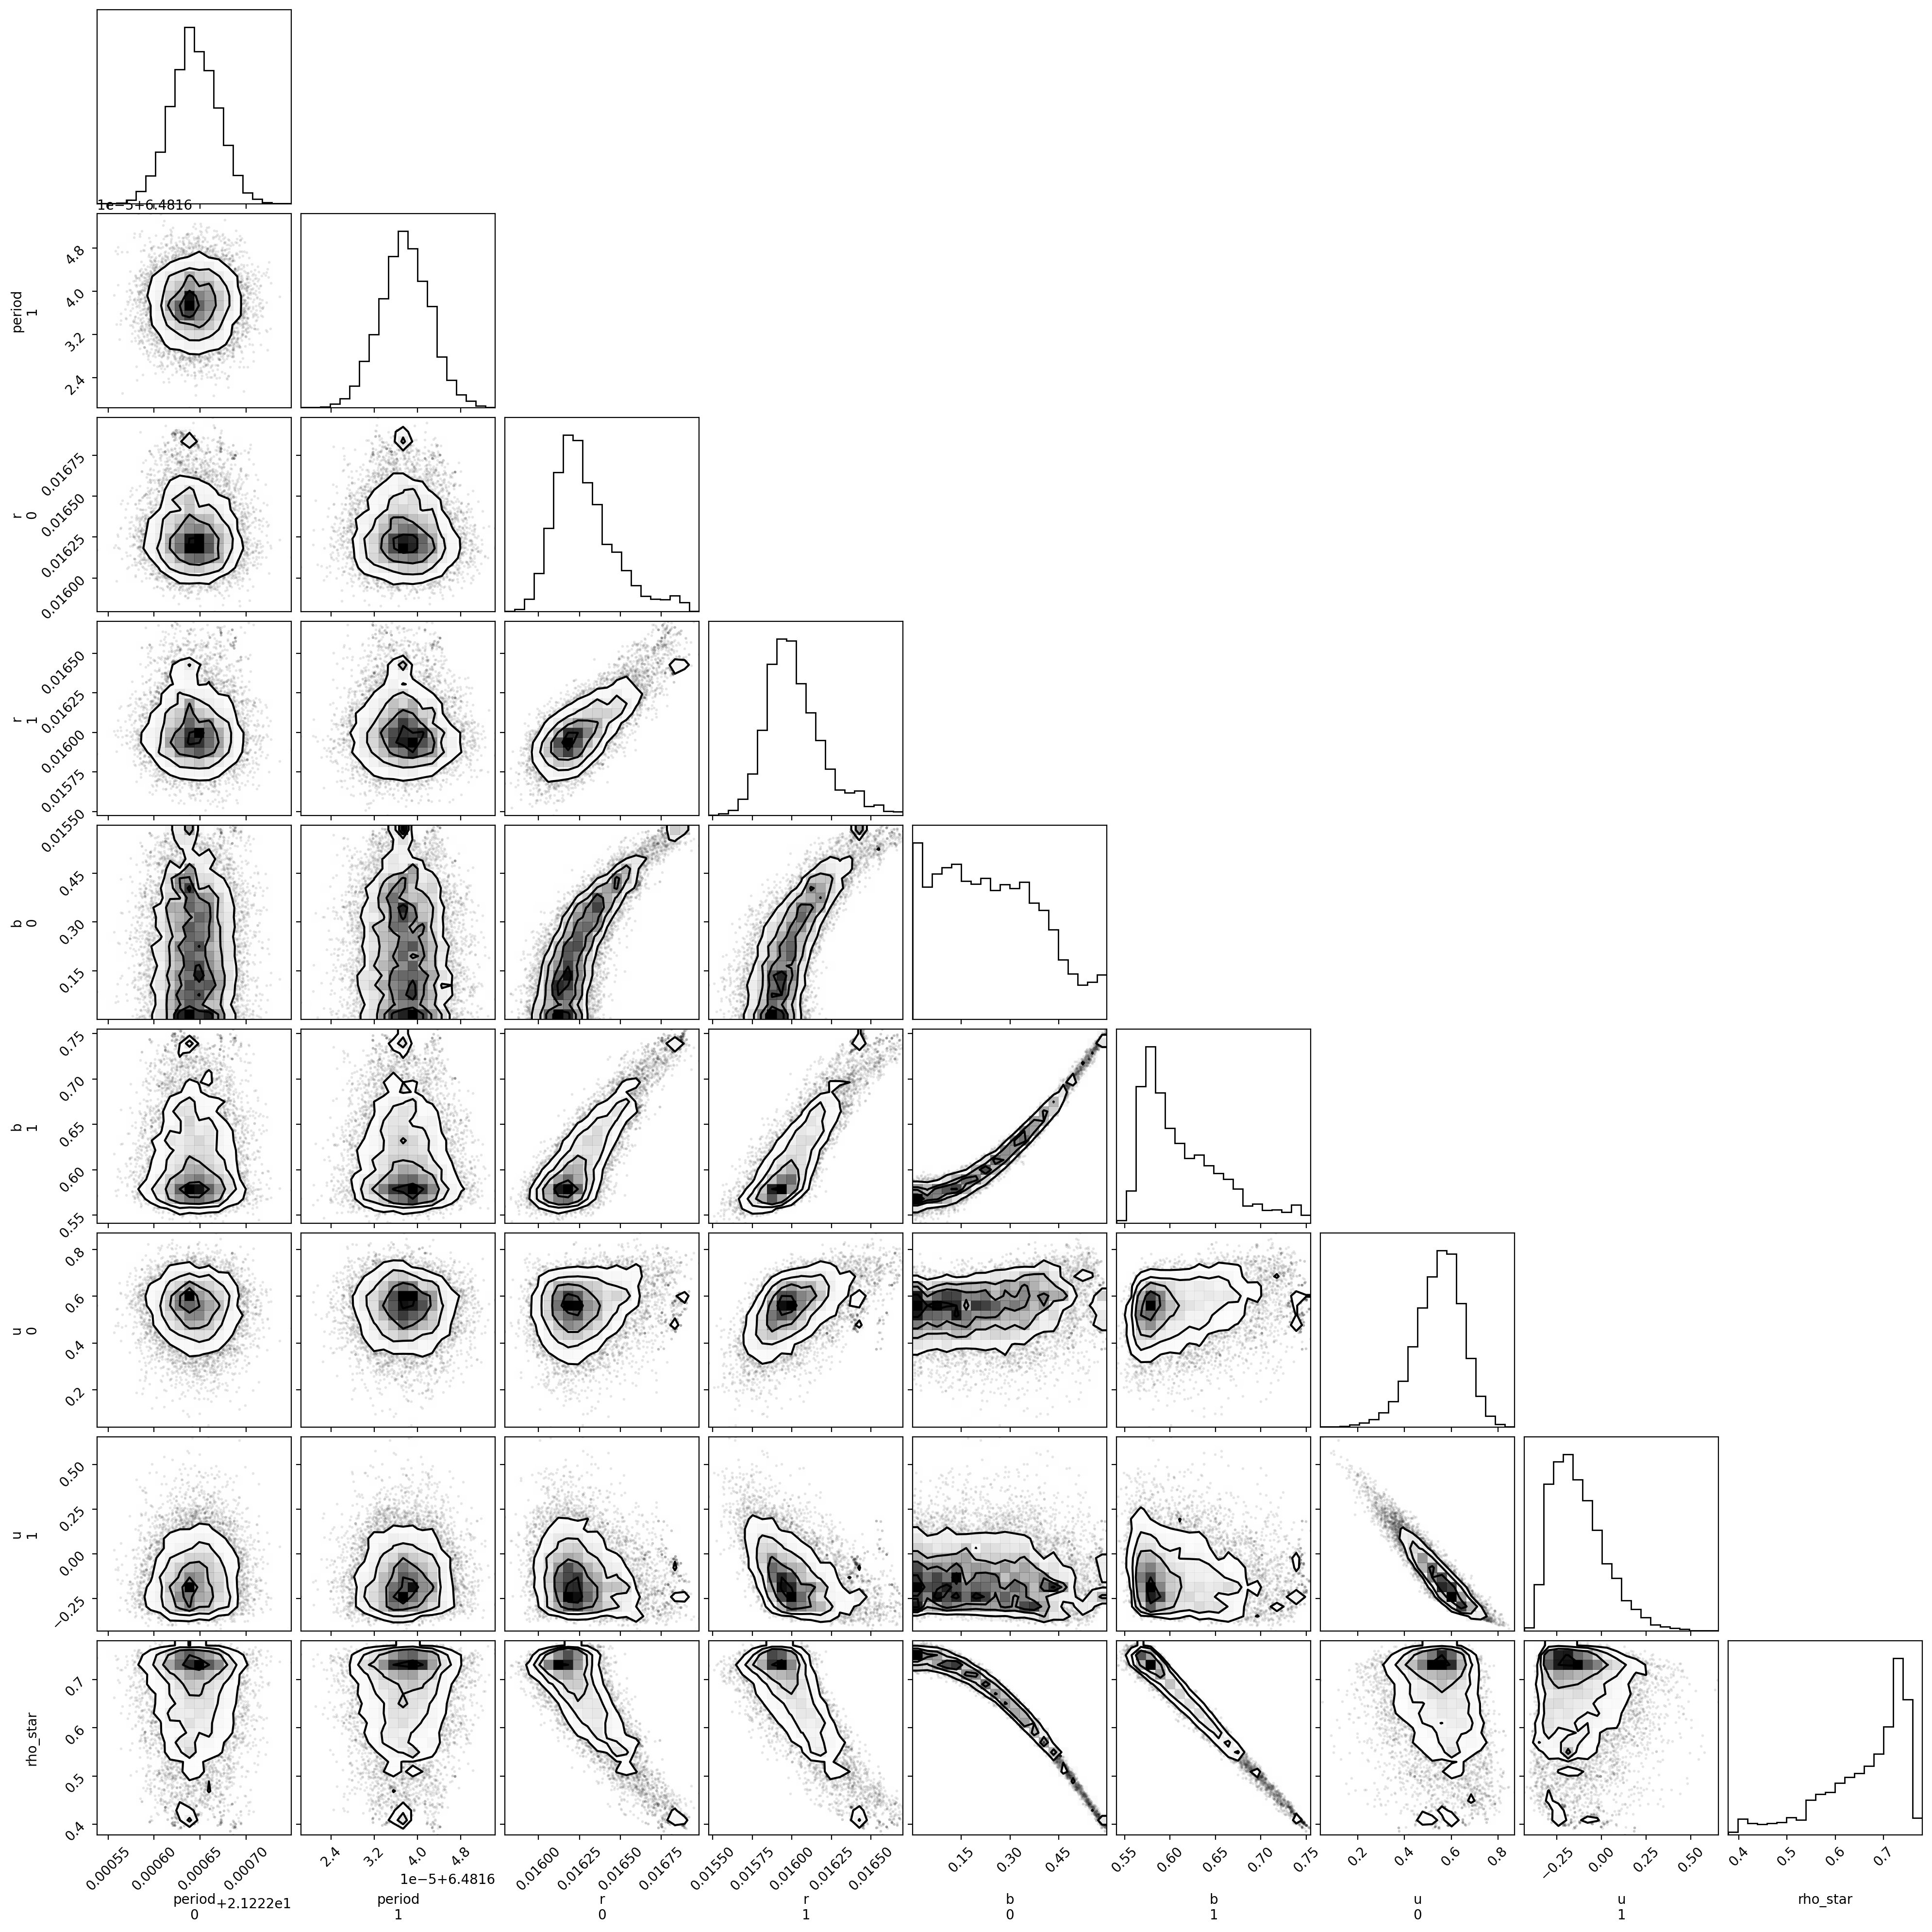

In [119]:
import corner
_ = corner.corner(
    trace,
    var_names=["period", "r", "b", "u", "rho_star"],
)
plt.show()

In [136]:
param_lists

{'pl_name': ['Kepler-109 c', 'Kepler-109 b'],
 'pl_letter': ['c', 'b'],
 'pl_orbper': [21.22265, 6.4816307],
 'pl_orbincl': [89.63, 87.06],
 'pl_orbeccen': [0.098, 0.11],
 'pl_trandep': [0.03599, 0.03015],
 'pl_tranmid': [2454970.5722, 2454955.97791],
 'pl_trandur': [6.4913, 3.649],
 'pl_ratror': [0.01734, 0.01686],
 'pl_imppar': [0.16, 0.58],
 'st_dens': [0.65, 0.65]}

# Separate into two independent planets

In [127]:
map_soln_p1, model_p1 = fit.optimise_model(lc, xo_archive.transpose_parameters(planet_parameters[0:1]))

optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 494250.9447988393 -> 494512.99640797934


In [130]:
map_soln_p2, model_p2 = fit.optimise_model(lc, xo_archive.transpose_parameters(planet_parameters[1:]))

optimizing logp for variables: [log_rho_star, b, r, u, logP, t0, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 496964.6664582009 -> 497303.2274136856


In [133]:
trace_p1 = fit.sample_posteriors(model_p1, map_soln_p1, cores=12, chains=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [log_rho_star, b, r, u, logP, t0, mean]


Sampling 12 chains for 1_000 tune and 1_000 draw iterations (12_000 + 12_000 draws total) took 1001 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 315 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4755069665003, but should be close to 0.9. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 428 divergences after tuning. Increase `target_accept` or repar

In [134]:
trace_p2 = fit.sample_posteriors(model_p2, map_soln_p2, cores=12, chains=12)

Multiprocess sampling (12 chains in 12 jobs)
NUTS: [log_rho_star, b, r, u, logP, t0, mean]


Sampling 12 chains for 1_000 tune and 1_000 draw iterations (12_000 + 12_000 draws total) took 1945 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 31 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


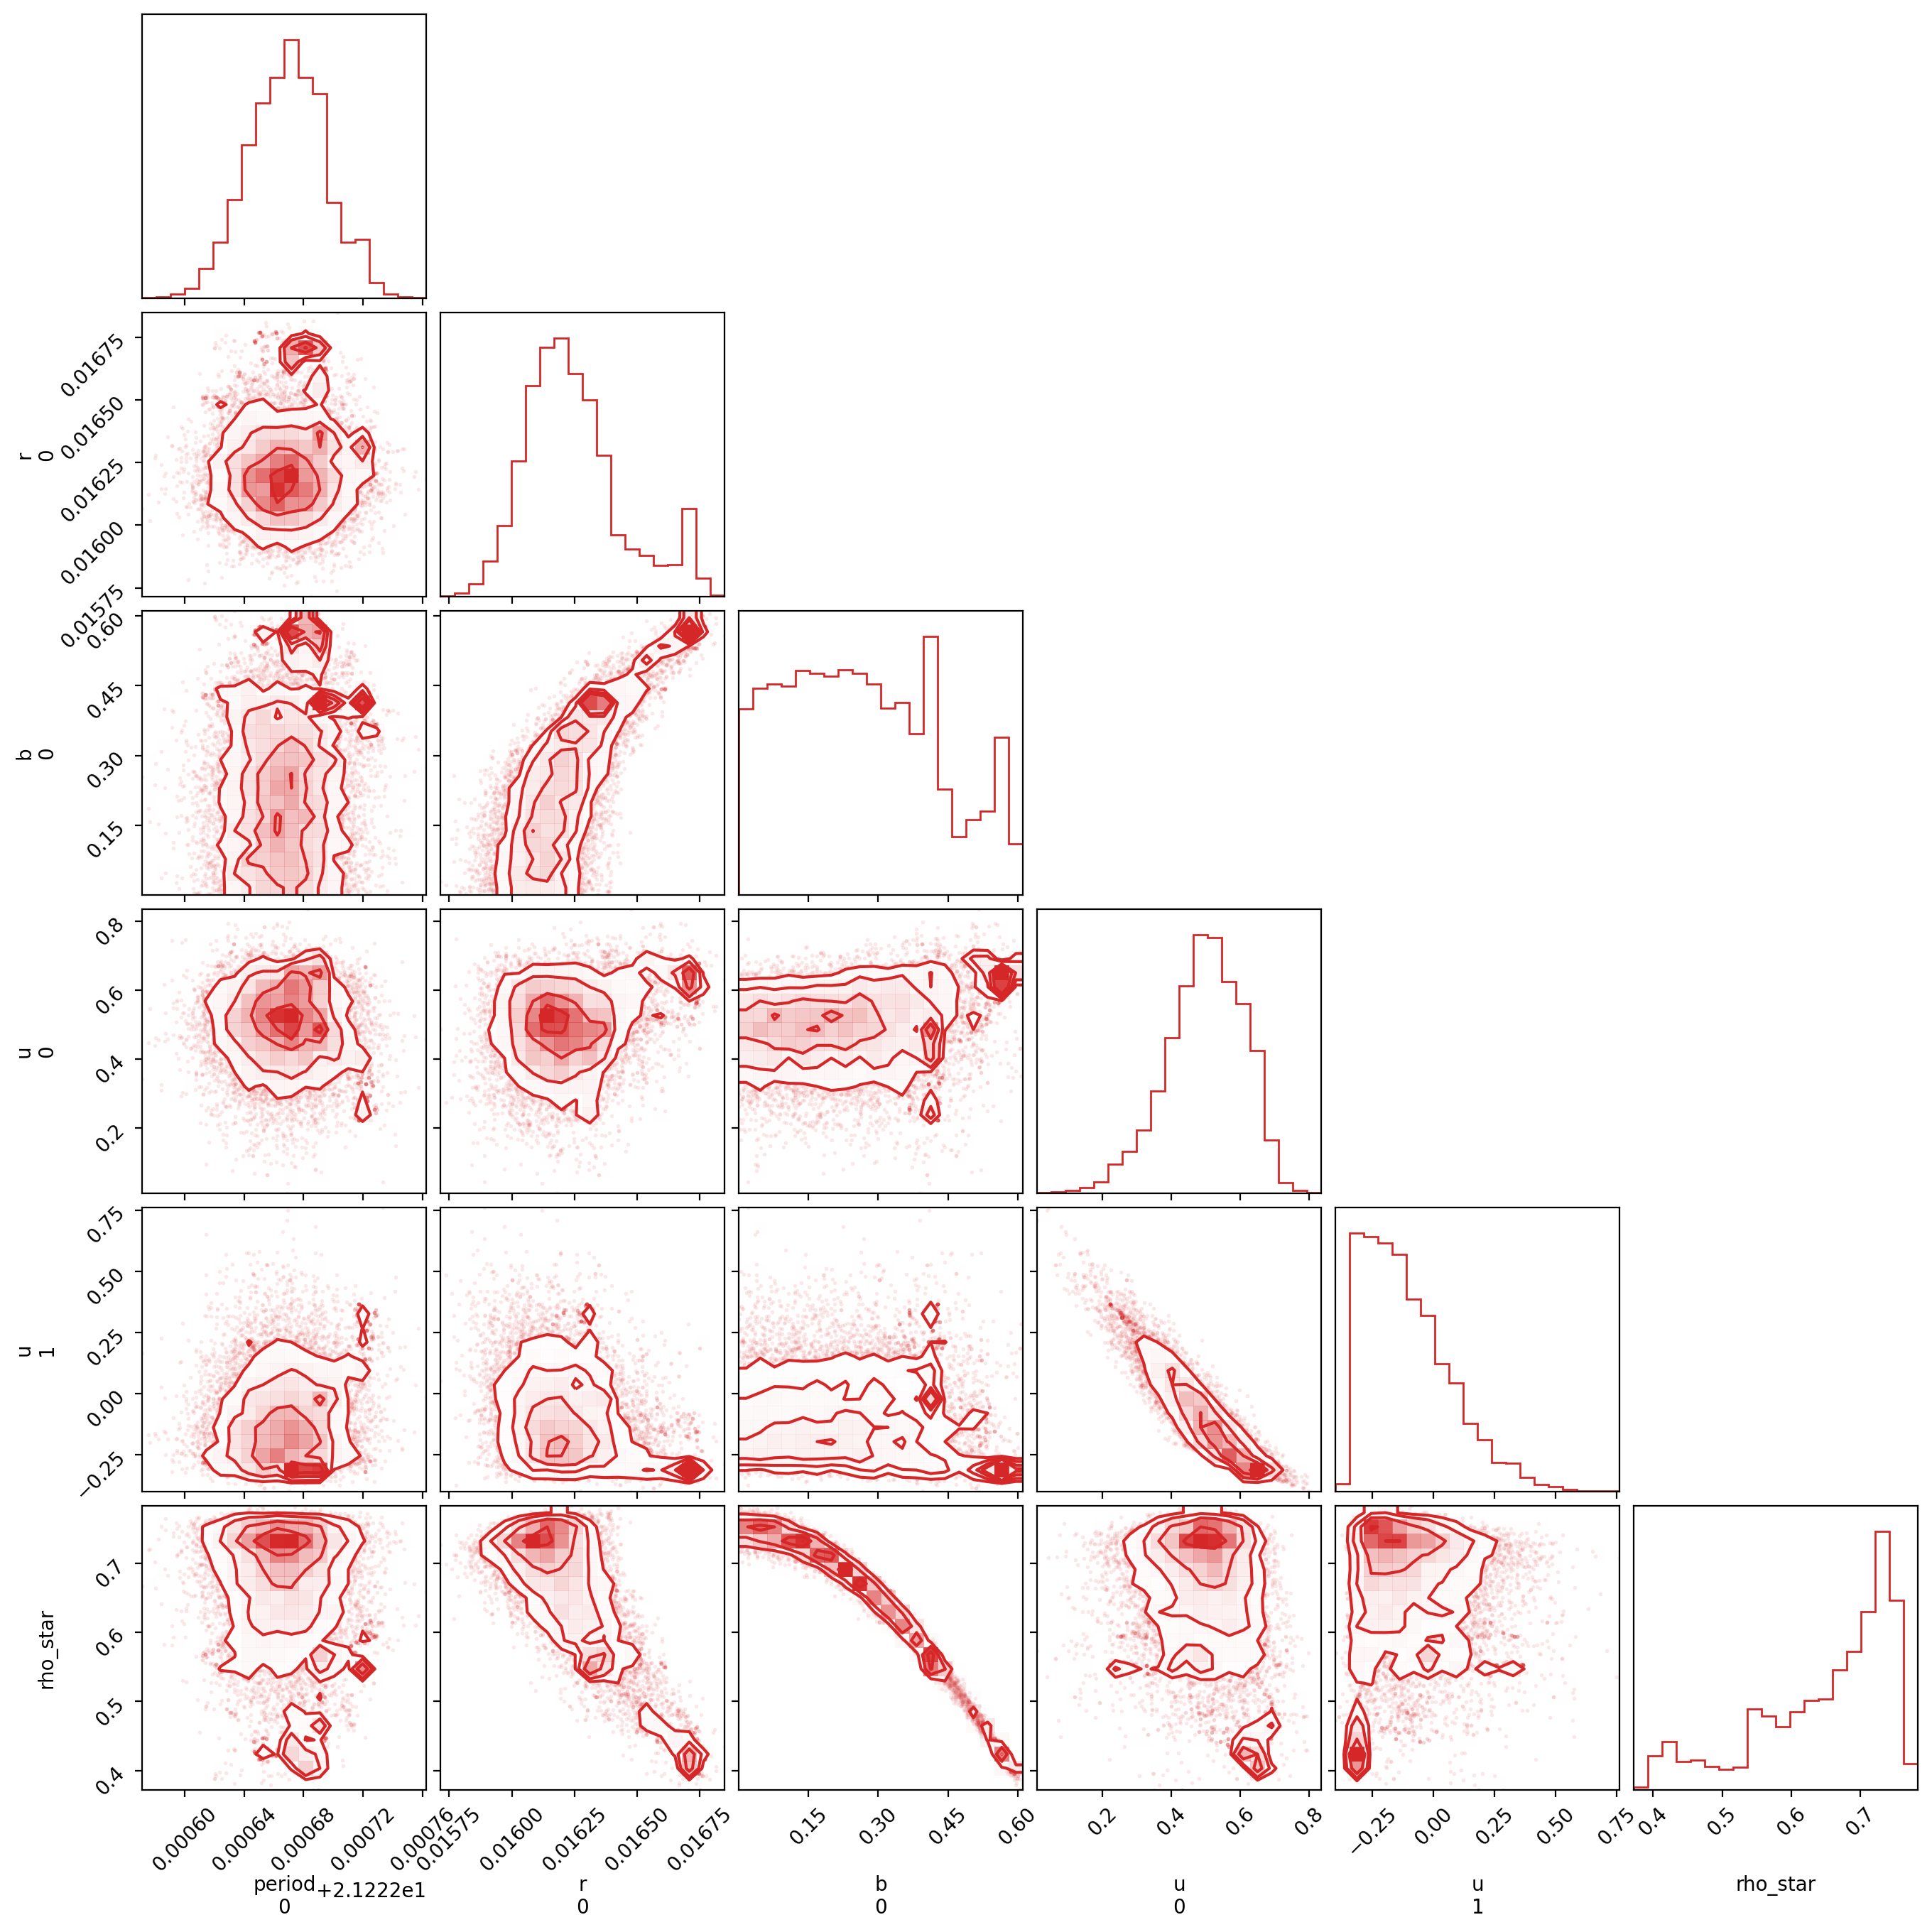

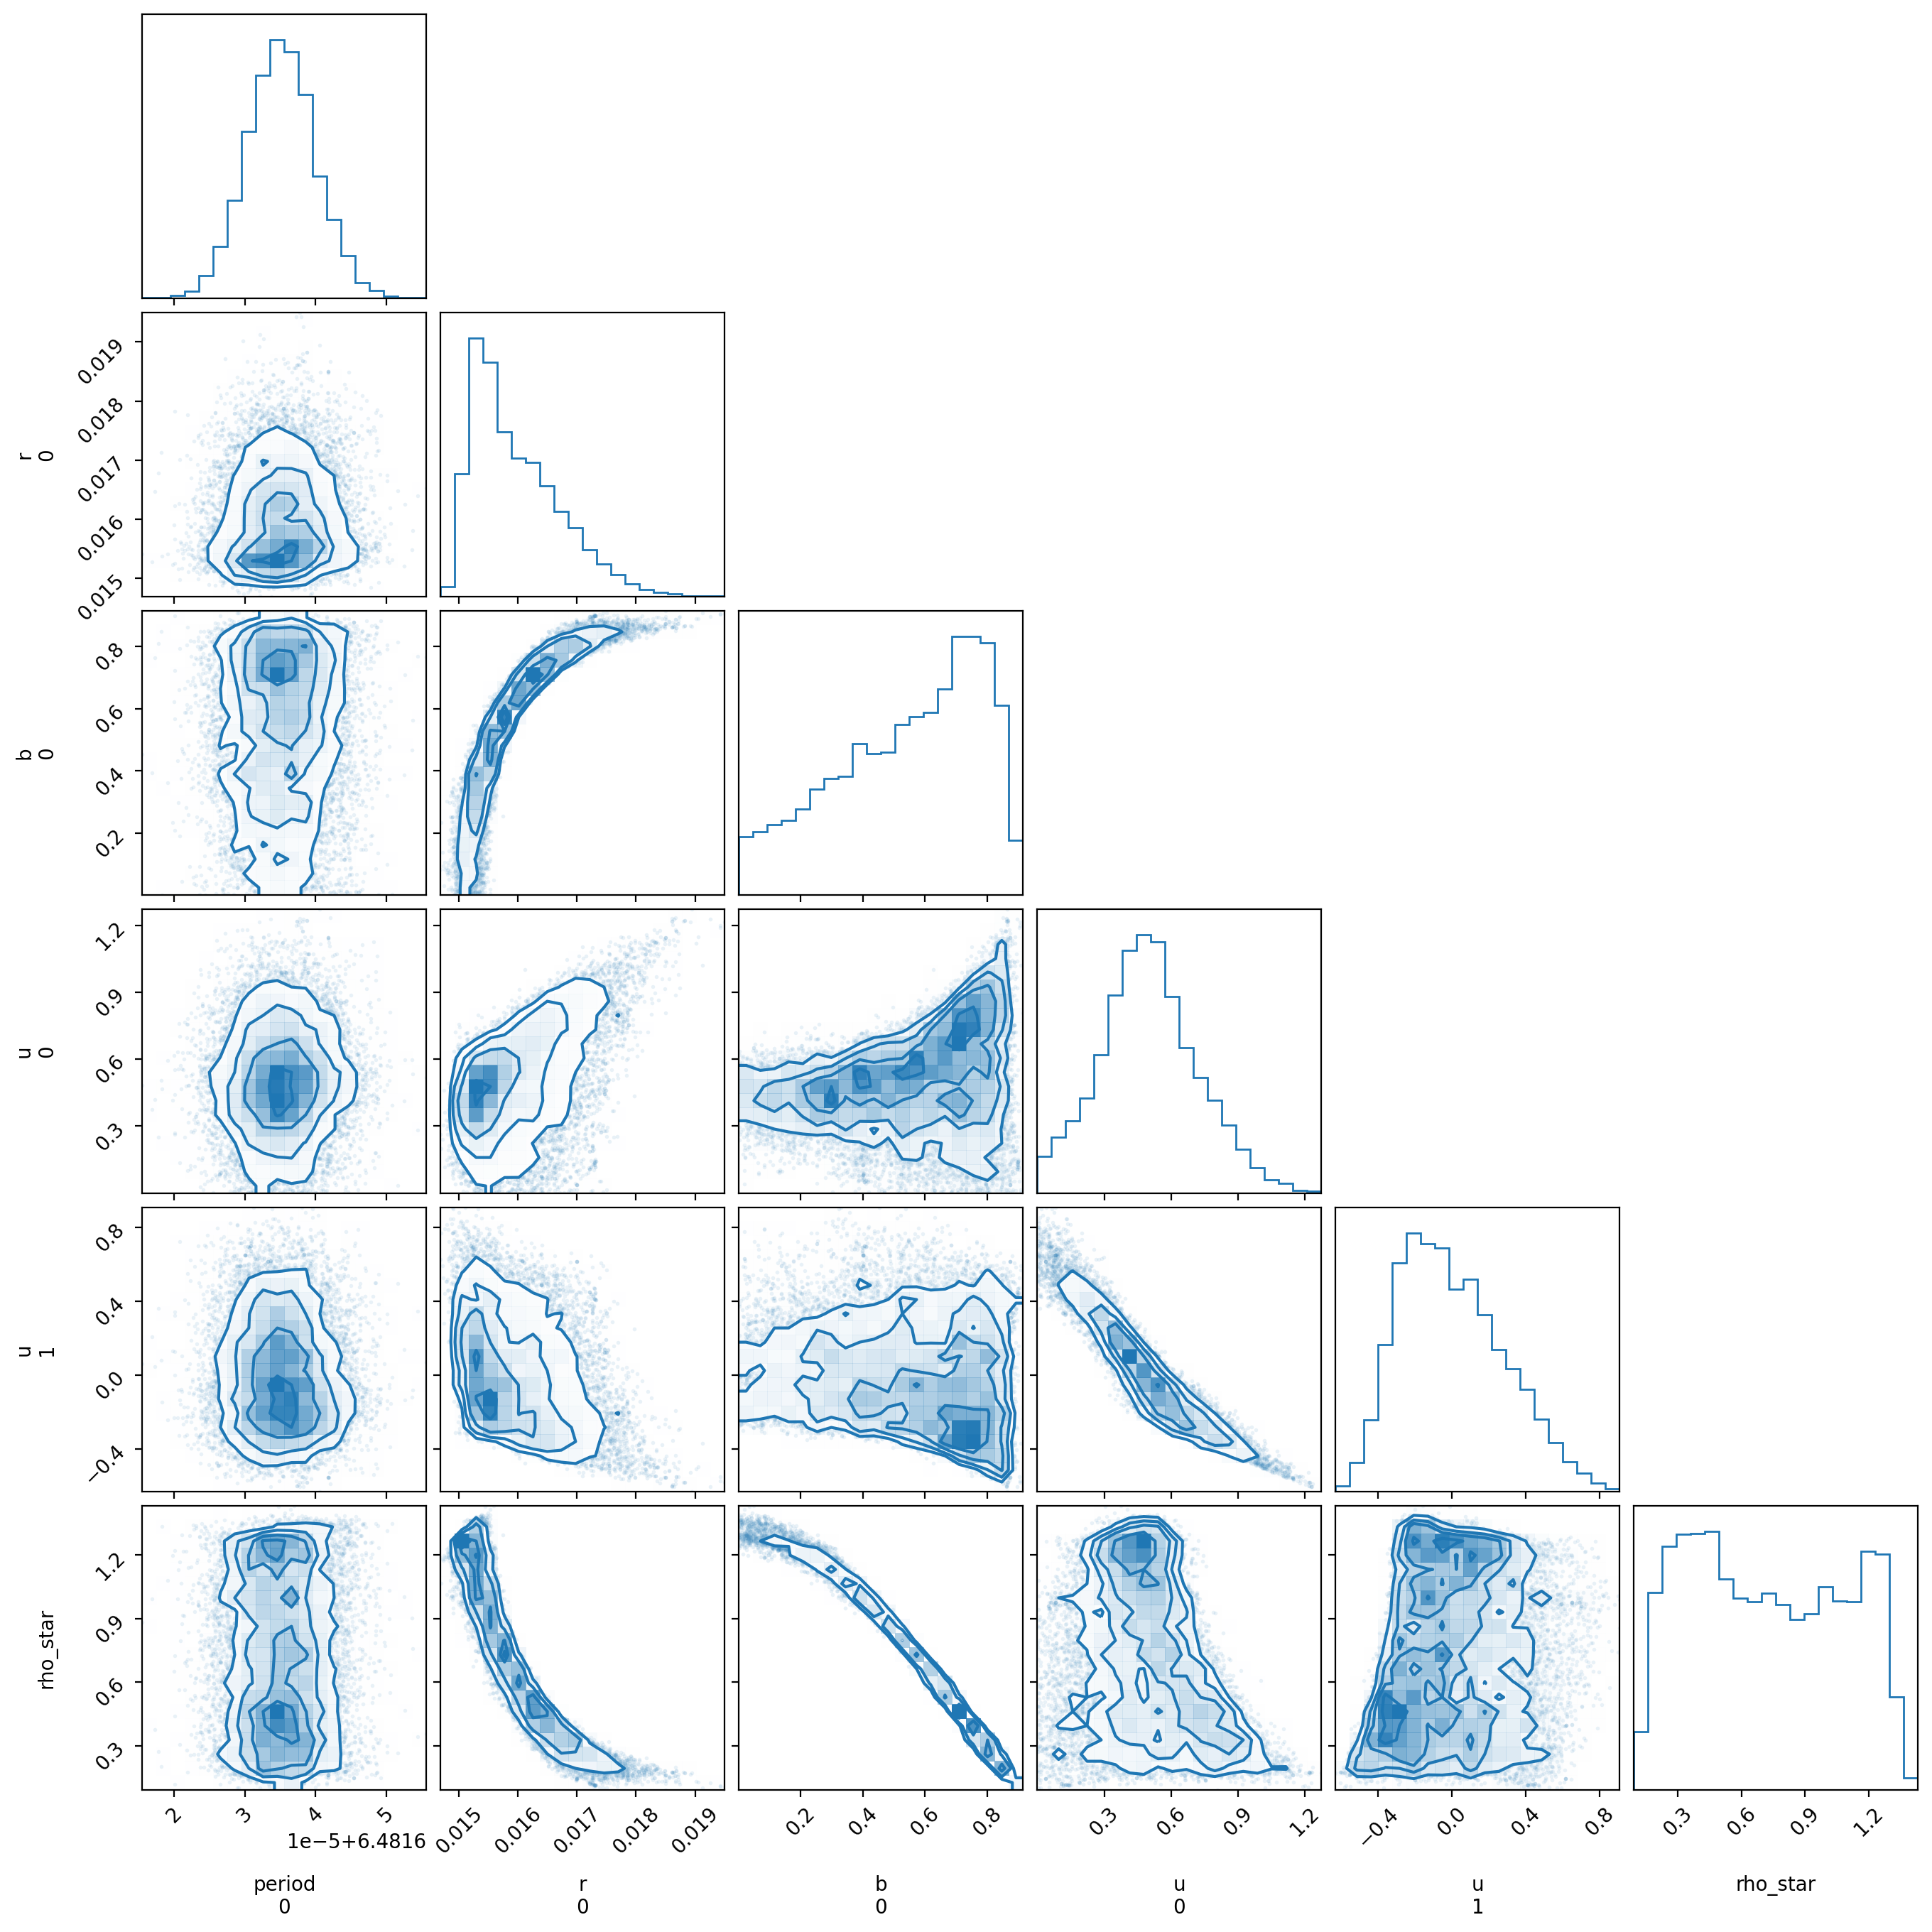

In [135]:
_ = corner.corner(
    trace_p1,
    var_names=["period", "r", "b", "u", "rho_star"],
    color="tab:red"
)
plt.show()

_ = corner.corner(
    trace_p2,
    var_names=["period", "r", "b", "u", "rho_star"],
    color="tab:blue"
)
plt.show()

# TODO
- Shoulders of the transit
    - May need a GP for this?
    - Understand what exoplanet is doing under the hood with the detrending
        - let's email DFM
    - Perhaps with lightkurve detrending just don't do it before handing it to exoplanet
- Short cadence data
    - May need a separate model for the short cadence data in Exoplanet
- Examine literature constraints of stellar parameters so we can place a better prior on the density of the star/limb darkening